# Book Rating ML prediction project

## Project Description
#### Book Rating Prediction Model

“There is no friend as loyal as a book.” - Ernest Hemingway
Nowadays with so many books available, it can be hard to select the best ones to read. The
dataset provided is a curation of Goodreads books based on real user information. It can be
used for many tasks like predicting a book’s rating or recommending new books.
Below is the information you have regarding the dataset attributes:


### Dataset attributes
There are 12 variables:
- bookID: A unique identification number for each book.
- title: The name under which the book was published.
- authors: The names of the authors of the book. Multiple authors are delimited by “/”.
- average_rating: The average rating of the book received in total.
- isbn: Another unique number to identify the book, known as the International Standard Book Number.
- isbn13: A 13-digit ISBN to identify the book, instead of the standard 11-digit ISBN.
- language_code: Indicates the primary language of the book. For instance, “eng” is standard for English.
- num_pages: The number of pages the book contains.
- ratings_count: The total number of ratings the book received.
- text_reviews_count: The total number of written text reviews the book received.
- publication_date: The date the book was published.
- publisher: The name of the book publisher.

In [2]:
# importing the necessary libraries
import numpy as np
import pandas as pd
import re #step 9 of cleaning stage
import matplotlib.pyplot as plt # analysis stage
import seaborn as sns # analysis stage

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
# read the file 
dataset = pd.read_csv("books.csv", encoding='UTF-8',on_bad_lines='skip')

In [4]:
# make a copy of dataframe to keep both in memory
df = dataset.copy() # use a copy in order to not modifying the original df

## Replicating cleaning operations performed in Excel to Python

### Data Cleaning Stage
- 1. DONE - DATA CLEANING - Inspect dataset: check datatypes, missing values
- 2. DONE - DATA CLEANING - Spaces before the title num_pages -> Remove them
- 3. DONE - DATA CLEANING - Transform publication date into datetime format 
- 4. DONE - DATA CLEANING - Too many authors (until 51) -> Keep only the first author who is the writer 'main_author' (individuato perchè è scritto prima della ',')
- 5. DONE - DATA CLEANING - Duplicates? - Common titles with different lines -> Keep the max value and add the number of votes
- 6. DONE - DATA CLEANING - Num pages with data 0 -> For 15 of them take the data of the identical book -> The rest, average by publisher
- 7. NO DISCREPANCY FOUND - DATA CLEANING - 4 lines discrepency between title and data -> Fix data with the right column	
- 8. DONE - DATA CLEANING - Publication date -> Split by year -> Split by season into numerical
- 9. DONE - DATA CLEANING - Language -> en-us, en-gb, eng tutti rinominati eng

###### Inspecting the original dataset
- 1. Check datatypes, missing values, describe data

In [5]:
df.head(5)

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
0,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,0439785960,9780439785969,eng,652,2095690,27591,9/16/2006,Scholastic Inc.
1,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,4.49,0439358078,9780439358071,eng,870,2153167,29221,9/1/2004,Scholastic Inc.
2,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,0439554896,9780439554893,eng,352,6333,244,11/1/2003,Scholastic
3,5,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling/Mary GrandPré,4.56,043965548X,9780439655484,eng,435,2339585,36325,5/1/2004,Scholastic Inc.
4,8,Harry Potter Boxed Set Books 1-5 (Harry Potte...,J.K. Rowling/Mary GrandPré,4.78,0439682584,9780439682589,eng,2690,41428,164,9/13/2004,Scholastic


In [6]:
# show Dataframe size (rows, columns)
df.shape  

# We have 11123 records with 12 columns in original dataset books.csv

(11123, 12)

In [7]:
df.info()
# There are 0 missing values
# data types seem coherent, publication_date is assimilated as object but can be transformed into date type


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11123 entries, 0 to 11122
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   bookID              11123 non-null  int64  
 1   title               11123 non-null  object 
 2   authors             11123 non-null  object 
 3   average_rating      11123 non-null  float64
 4   isbn                11123 non-null  object 
 5   isbn13              11123 non-null  int64  
 6   language_code       11123 non-null  object 
 7     num_pages         11123 non-null  int64  
 8   ratings_count       11123 non-null  int64  
 9   text_reviews_count  11123 non-null  int64  
 10  publication_date    11123 non-null  object 
 11  publisher           11123 non-null  object 
dtypes: float64(1), int64(5), object(6)
memory usage: 1.0+ MB


In [8]:
df.describe(include='all')
# We observe some redundancy in titles (10348 unique)
# We observe some redundancy in Authors (6639 unique), Stephen King has the most works
# We observe 27 unique languages, with eng books dominating the dataset (8908)
# There are 2290 unique publishers with Vintage being the most common (318 works)
# Average Rating mean is 3.93, 25% is 3.77, median is 3.96, 75% is 4.14. Ratings are mostly high and spread is small (std : 0.35). Skewness seems low
# num_pages mean is 336 vs median 299, exhibits some skewness because of outliers (top 6576)
# ratings_count mean is 1.79e+04 vs median 7.45e+02, exhibiting strong skewness as top value is > 1e+6
# text_reviews_count mean is 542 vs median 47, exhibiting high skewness with a top value of 94265

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
count,11123.000000,11123,11123,11123.000000,11123,1.112300e+04,11123,11123.000000,1.112300e+04,11123.000000,11123,11123
unique,NaN,10348,6639,NaN,11123,NaN,27,NaN,NaN,NaN,3679,2290
top,NaN,The Iliad,Stephen King,NaN,0439785960,NaN,eng,NaN,NaN,NaN,10/1/2005,Vintage
freq,NaN,9,40,NaN,1,NaN,8908,NaN,NaN,NaN,56,318
mean,21310.856963,NaN,NaN,3.934075,NaN,9.759880e+12,NaN,336.405556,1.794285e+04,542.048099,NaN,NaN
std,13094.727252,NaN,NaN,0.350485,NaN,4.429758e+11,NaN,241.152626,1.124992e+05,2576.619589,NaN,NaN
min,1.000000,NaN,NaN,0.000000,NaN,8.987060e+09,NaN,0.000000,0.000000e+00,0.000000,NaN,NaN
25%,10277.500000,NaN,NaN,3.770000,NaN,9.780345e+12,NaN,192.000000,1.040000e+02,9.000000,NaN,NaN
50%,20287.000000,NaN,NaN,3.960000,NaN,9.780582e+12,NaN,299.000000,7.450000e+02,47.000000,NaN,NaN
75%,32104.500000,NaN,NaN,4.140000,NaN,9.780872e+12,NaN,416.000000,5.000500e+03,238.000000,NaN,NaN


In [9]:
# show column names in list
df.columns

Index(['bookID', 'title', 'authors', 'average_rating', 'isbn', 'isbn13', 'language_code', '  num_pages', 'ratings_count', 'text_reviews_count', 'publication_date', 'publisher'], dtype='object')

###### Check column names and unify text as lowercase
- 2. Rename columns correctly, everything lowercase and without blank spaces

In [10]:
# convert all the columns to small case
df.columns = map(str.lower, df.columns)
df.columns
# ! num_page column has 2 blank spaces

Index(['bookid', 'title', 'authors', 'average_rating', 'isbn', 'isbn13', 'language_code', '  num_pages', 'ratings_count', 'text_reviews_count', 'publication_date', 'publisher'], dtype='object')

In [11]:
# removing the blank spaces in the num_pages column name
newcols = {'  num_pages': 'num_pages'}
df = df.rename(columns=newcols)

In [12]:
# convert every string in lowercase except for isbn since it is an identifier
df['title']=df['title'].str.lower()
df['authors']=df['authors'].str.lower()
df['language_code']=df['language_code'].str.lower()
df['publisher']=df['publisher'].str.lower()

In [13]:
df.sample()

,bookid,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
5684,21187,for all time (time travelers #4),caroline b. cooney,3.9,0440229316,9780440229315,eng,261,1618,65,7/8/2003,laurel leaf library


###### Check datatypes
- 3. Correct data types

In [14]:
# show column datatypes
df.dtypes
# ! publication_date is object instead of date

bookid                  int64
title                  object
authors                object
average_rating        float64
isbn                   object
isbn13                  int64
language_code          object
num_pages               int64
ratings_count           int64
text_reviews_count      int64
publication_date       object
publisher              object
dtype: object

In [15]:
df['publication_date'].head()
# month, day, year format date

0    9/16/2006
1     9/1/2004
2    11/1/2003
3     5/1/2004
4    9/13/2004
Name: publication_date, dtype: object

In [16]:
df['publication_date1'] = pd.to_datetime(df['publication_date'], format='%m/%d/%Y', errors="coerce")
# errors = 'coerce' because some days cant't be formatted

In [17]:
# find how many rows present the issue
df['publication_date1'].isna().sum()

2

In [18]:
# display the rows rows which present the issue
df[['publication_date', 'publication_date1']][df['publication_date1'].isna()]

,publication_date,publication_date1
8177,11/31/2000,NaT
11094,6/31/1982,NaT


In [19]:
# June and November have 30 days but here the day is set to 31 which should be impossible, we change it in 3oth
df.at[8177,'publication_date']='11/30/2000'
df.at[11094,'publication_date']= '6/30/1982'

In [20]:
# check if the error comes up again and do the datatype transformation on the original column, solved
df['publication_date'] = pd.to_datetime(df['publication_date'], format='%m/%d/%Y')

In [21]:
# drop the 'publication_date1' column since it is not useful anymore
df = df.drop('publication_date1', axis=1)

###### Find the first author for each book
- 4. Keep just one author for each book (the first one) and store it in a new column; add binary variable for multiple authors and one variable that counts the number of authors in 'authors'

In [28]:
# We transform the authors string into a list of authors
df['authors_list'] = df['authors'].str.split('/')
# We get the main author
df['main_author'] = df['authors_list'].str[0]

In [31]:
# We check if there are invalid authors
display(df['main_author'].describe())
print(df[df['main_author'].isna()])
df['nb_authors'] = df['authors_list'].str.len()

In [47]:
display(df['nb_authors'].describe())
df['nb_authors'].value_counts()

count    11123.000000
mean         1.729479
std          1.820111
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         51.000000
Name: nb_authors, dtype: float64

1     6561
2     3078
3     1005
4      222
5       65
6       54
7       21
10      12
8       11
15      11
9       10
11       9
21       8
18       8
13       8
16       6
17       6
12       5
19       4
20       3
24       3
23       2
14       1
26       1
27       1
28       1
51       1
35       1
33       1
38       1
22       1
25       1
32       1
Name: nb_authors, dtype: int64

In [44]:
df.loc[df['nb_authors'] > 1 , 'multiple_authors'] = 1
df.loc[~(df['nb_authors'] > 1 ), 'multiple_authors'] = 0
df['multiple_authors'].astype(int)

###### Inspect duplicates in the dataset
- 5. Keep 1 row for each unique title summing the info regarding rating, n. of pages, etc..

In [79]:
df['title'].duplicated().value_counts()

False    10311
True       812
Name: title, dtype: int64

In [48]:
df[['title', 'average_rating','ratings_count','text_reviews_count', 'num_pages']][df['title'].duplicated()]

,title,average_rating,ratings_count,text_reviews_count,num_pages
10,the hitchhiker's guide to the galaxy (hitchhik...,4.22,1266,253,6
24,the lord of the rings (the lord of the rings ...,4.50,1618,140,1216
37,the changeling,3.55,301,43,339
40,the known world,3.83,55,12,14
41,the known world,3.83,22,3,576
...,...,...,...,...,...
11076,artemis fowl (artemis fowl #1),3.84,55,14,6
11078,the subtle knife (his dark materials #2),4.13,677,77,326
11080,the subtle knife (his dark materials #2),4.13,39,8,8
11096,on the road,3.63,3271,342,307


In [49]:
# new updated column for ratings count that sums all ratings count when the title is the same
df['ratings_count_updt']=df.groupby(['title'])['ratings_count'].transform('sum')

In [50]:
# new updated column for text reviews count that sums all review count when the title is the same
df['text_reviews_count_updt']=df.groupby(['title'])['text_reviews_count'].transform('sum')

In [51]:
# useful for next stage regarding num pages, must be done before dropping duplicates
# new updated column for num_pages that store max value when the title is the same
# or mean instead of max?? sometimes looking at the Salem's lot book the max is 817, the min is 0, another 17
# the rest takes value from 405 to 594 and checking it online it should be smt between 439 and 670 depending on the version
df['max_pages']=df.groupby(['title'])['num_pages'].transform('max')

In [52]:
# check for title 'the known world'
df[['title', 'average_rating','ratings_count','text_reviews_count','ratings_count_updt', 'num_pages', 'max_pages']][df['title']=='the known world']

,title,average_rating,ratings_count,text_reviews_count,ratings_count_updt,num_pages,max_pages
39,the known world,3.83,29686,2626,30212,388,576
40,the known world,3.83,55,12,30212,14,576
41,the known world,3.83,22,3,30212,576,576
3193,the known world,3.83,449,83,30212,388,576


In [53]:
# check for title 'salem's lot
df[['title', 'average_rating','ratings_count','text_reviews_count','ratings_count_updt', 'num_pages', 'max_pages']][df['title']=="'salem's lot"]

,title,average_rating,ratings_count,text_reviews_count,ratings_count_updt,num_pages,max_pages
1572,'salem's lot,4.25,84123,571,85852,594,817
1573,'salem's lot,4.02,227,54,85852,17,817
1574,'salem's lot,4.02,1039,130,85852,405,817
1576,'salem's lot,4.02,178,35,85852,427,817
1577,'salem's lot,4.02,25,6,85852,586,817
5298,'salem's lot,4.02,56,5,85852,0,817
5300,'salem's lot,4.02,18,3,85852,817,817
9249,'salem's lot,4.02,186,22,85852,427,817


In [54]:
# check with the new columns
df[['title', 'average_rating','ratings_count','text_reviews_count','ratings_count_updt', 'text_reviews_count_updt', 'num_pages', 'max_pages']][df['title'].duplicated()]

,title,average_rating,ratings_count,text_reviews_count,ratings_count_updt,text_reviews_count_updt,num_pages,max_pages
10,the hitchhiker's guide to the galaxy (hitchhik...,4.22,1266,253,12107,1261,6,216
24,the lord of the rings (the lord of the rings ...,4.50,1618,140,4161,290,1216,1216
37,the changeling,3.55,301,43,1477,139,339,339
40,the known world,3.83,55,12,30212,2724,14,576
41,the known world,3.83,22,3,30212,2724,576,576
...,...,...,...,...,...,...,...,...
11076,artemis fowl (artemis fowl #1),3.84,55,14,528,41,6,286
11078,the subtle knife (his dark materials #2),4.13,677,77,5466,422,326,326
11080,the subtle knife (his dark materials #2),4.13,39,8,5466,422,8,326
11096,on the road,3.63,3271,342,9334,883,307,320


In [55]:
# now keep just the observation with max average_rating for each title

In [56]:
df = df.sort_values(['average_rating'], ascending=False).drop_duplicates(['title'],keep= 'first')

In [57]:
# check for title 'the known world'
df[['title', 'average_rating','ratings_count','text_reviews_count','ratings_count_updt', 'num_pages', 'max_pages']][df['title']=='the known world']

,title,average_rating,ratings_count,text_reviews_count,ratings_count_updt,num_pages,max_pages
40,the known world,3.83,55,12,30212,14,576


In [58]:
df['title'].duplicated().value_counts()

False    10311
Name: title, dtype: int64

###### Deal with very low value of number of pages
- 6.1 Column max_pages created in previous step to fill the n.pages with the value found in another row with same book title (from 76 rows with num_page = 0 to 61)
- 6.2 Fill n.pages = 0 with average pages of the author (from 61 to 20)
- 6.3 Fill n.pages = 0 with average pages of the publisher (from 20 to 4)
- 6.4 Take the index of the rows with n.pages = 0 and assign the n. of pages found online (from 4 to 0)

###### Should we do the same operations for low num_page (<50) ?

In [59]:
# inspect how many rows have num pages=0
#df.sort_values(by=['max_pages']).head(100)
df[df['max_pages'] == 0 ]

,bookid,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher,authors_list,main_author,nb_authors,multiple_authors,ratings_count_updt,text_reviews_count_updt,max_pages
4811,17277,the feynman lectures on physics vols 7-8,richard p. feynman,4.80,0738209279,9780738209272,en-us,0,20,0,2006-01-03,basic books,[richard p. feynman],richard p. feynman,1,0.0,20,0,0
4810,17276,the feynman lectures on physics vols 3-4,richard p. feynman,4.71,0738209252,9780738209258,en-us,0,21,0,2004-05-12,basic books,[richard p. feynman],richard p. feynman,1,0.0,21,0,0
306,955,the 5 love languages / the 5 love languages jo...,gary chapman,4.70,0802415318,9780802415318,eng,0,22,4,2005-01-01,moody publishers,[gary chapman],gary chapman,1,0.0,22,4,0
8447,32498,john grisham value collection: a time to kill ...,john grisham/michael beck/blair brown/d.w. mof...,4.50,0739312642,9780739312643,eng,0,476,9,2004-06-01,random house audio,"[john grisham, michael beck, blair brown, d.w....",john grisham,4,1.0,476,9,0
4973,17983,the reverse of the medal (aubrey/maturin #11),patrick o'brian/simon vance,4.41,0786178183,9780786178186,en-gb,0,3598,93,2006-02-01,blackstone audiobooks,"[patrick o'brian, simon vance]",patrick o'brian,2,1.0,3598,93,0
3730,13504,a clash of kings (a song of ice and fire #2),george r.r. martin/roy dotrice,4.41,073930870X,9780739308707,eng,0,113,12,2004-02-17,random house audio,"[george r.r. martin, roy dotrice]",george r.r. martin,2,1.0,113,12,0
9914,39959,the carl hiaasen collection: lucky you and sic...,carl hiaasen/edward asner,4.32,0739340824,9780739340820,en-us,0,90,5,2006-06-06,random house audio,"[carl hiaasen, edward asner]",carl hiaasen,2,1.0,90,5,0
10018,40343,the full box (full #1-4),janet evanovich/charlotte hughes,4.29,1593979266,9781593979263,eng,0,101,3,2016-02-16,macmillan audio,"[janet evanovich, charlotte hughes]",janet evanovich,2,1.0,101,3,0
5866,22077,the michael crichton collection: jurassic park...,michael crichton/chris noth/anthony heald,4.29,0375415807,9780375415807,eng,0,107,3,2000-06-09,random house audio,"[michael crichton, chris noth, anthony heald]",michael crichton,3,1.0,107,3,0
5841,21933,point of impact (bob lee swagger #1),stephen hunter/beau bridges,4.27,0739344242,9780739344248,eng,0,15,1,2007-01-09,rh audio,"[stephen hunter, beau bridges]",stephen hunter,2,1.0,15,1,0


In [60]:
# subset with all obs where num pages = 0 using the new column max_pages created during point 5 before dropping duplicates
maxnopage = df[df['max_pages'] == 0]

In [61]:
maxnopage.shape # before adding column max_pages (76,15), then 61,16

(61, 19)

In [94]:
# compute average num_pages for each author and same for publisher

In [63]:
#see what's the average max number of pages for each author in main_author38
avgnumpagexauth = df.groupby(["main_author"]).mean().max_pages 

C:\Users\diego\AppData\Local\Temp\ipykernel_42592\1901504977.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  avgnumpagexauth = df.groupby(["main_author"]).mean().max_pages


In [64]:
avgnumpagexauth

main_author
a.b. yehoshua            416.000000
a.d.p. briggs            256.000000
a.e. cunningham          232.000000
a.j. jacobs              389.000000
a.m. homes               256.000000
                            ...    
zora neale hurston       426.600000
zoë heller               251.000000
åsne seierstad           291.333333
émile zola               459.444444
éric-emmanuel schmitt     85.000000
Name: max_pages, Length: 4188, dtype: float64

In [65]:
avgnumpagexauthDICT = df.groupby(["main_author"]).mean().num_pages.astype(int).to_dict()

C:\Users\diego\AppData\Local\Temp\ipykernel_42592\2042270337.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  avgnumpagexauthDICT = df.groupby(["main_author"]).mean().num_pages.astype(int).to_dict()


In [66]:
avgnumpagexauthDICT.keys()

dict_keys(['a.b. yehoshua', 'a.d.p. briggs', 'a.e. cunningham', 'a.j. jacobs', 'a.m. homes', 'a.n. roquelaure', 'a.s. byatt', 'abbie hoffman', 'abdul rahman munif', 'abigail adams', 'abigail thomas', 'abolqasem ferdowsi', 'abraham lincoln', 'adam  sexton', 'adam drozdek', 'adam ginsberg', 'adam gopnik', 'adam hochschild', 'adam mansbach', 'adam rex', 'adam smith', 'adam swift', 'adam woog', 'adolfo bioy casares', 'adrian guelke', 'adrian mckinty', 'adèle geras', 'aeschylus', 'aesop', 'agatha christie', 'ai morinaga', 'aidan hartley', 'aimee bender', 'aimé césaire', 'akira yoshida', 'al franken', 'al gore', 'al ries', 'alain de botton', 'alan  lee', 'alan aldridge', 'alan brennert', 'alan cohen', 'alan dean foster', 'alan hausman', 'alan hollinghurst', 'alan lightman', 'alan macgillivray', 'alan moore', 'alan paton', 'alastair lamb', 'albert camus', 'albert demeo', 'albert einstein', 'albert ellis', 'albert jack', 'albert marrin', 'albert speer', 'alcoholics anonymous', 'alden t. vaugha

In [67]:
def numpage_guesser_auth(main_author38): #guess average numpage based on author
    numpage = avgnumpagexauthDICT[main_author38] 
    return numpage

In [68]:
numpage_guesser_auth('agatha christie')

249

In [75]:
#loop over every dictionary key 
# go to df locate the df with a certain author and all columns (store everything in a new df)
# get rows where max_numpage=0 and use the numpage guesser function to fill numpage= 0 
for main_author38 in avgnumpagexauthDICT.keys():
    temp_df = df.loc[(df.main_author==main_author38),:]
    zero_values_index = temp_df.loc[(temp_df['max_pages'] == 0)].index
    df.loc[zero_values_index,"max_pages"] = numpage_guesser_auth(main_author38)

In [76]:
df[df['max_pages'] == 0].shape #from 61 to 13

(13, 19)

In [77]:
#repeat for publisher

In [78]:
#see what's the average max number of pages for each publisher
avgnumpagexpubl = df.groupby(["publisher"]).mean().max_pages #seems that 

C:\Users\diego\AppData\Local\Temp\ipykernel_42592\609537851.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  avgnumpagexpubl = df.groupby(["publisher"]).mean().max_pages #seems that


In [79]:
avgnumpagexpubl

publisher
10/18                            191.000000
1st book library                 600.000000
1st world library                387.000000
a & c black (childrens books)     62.000000
a harvest book/harcourt  inc.    216.000000
                                    ...    
聯經出版事業股份有限公司                     537.500000
英文漢聲出版股份有限公司                      36.000000
角川書店 (kadokawa shoten)           171.500000
講談社                              186.833333
集英社                              199.500000
Name: max_pages, Length: 2184, dtype: float64

In [80]:
avgnumpagexpublDICT = df.groupby(["publisher"]).mean().num_pages.astype(int).to_dict()

C:\Users\diego\AppData\Local\Temp\ipykernel_42592\1049260121.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  avgnumpagexpublDICT = df.groupby(["publisher"]).mean().num_pages.astype(int).to_dict()


In [81]:
avgnumpagexpublDICT.keys()

dict_keys(['10/18', '1st book library', '1st world library', 'a & c black (childrens books)', 'a harvest book/harcourt  inc.', 'a k peters', 'abacus', 'abacus books', 'abacus books (london)', 'abdo publishing company', 'abingdon press', 'abradale books/harry n. abrams', 'abraham guillen press', 'abrams', 'absolute press', 'abstract studio', 'academic press', 'academica press', 'academy chicago publishers', 'ace', 'ace book', 'ace books', 'ace hardcover', 'ace trade', 'acento editorial', 'acropolis books (ny)', 'actes sud', 'adams media', 'addison wesley', 'addison wesley publishing company', 'addison-wesley professional', 'adv manga', 'advantage world press', 'adventures unlimited press', 'aegypan', 'aha! process', 'ait planet lar', 'aivia press', 'ak press', 'akashic books/punk planet books', 'aladdin', 'aladdin paperbacks', 'alan rodgers books', 'albert whitman  company', 'albin michel', 'albury publishing', 'alcoholics anonymous world services inc', 'alderac entertainment group', 'a

In [82]:
def numpage_guesser_publ(publisher): #guess average numpage based on author
    numpage = avgnumpagexpublDICT[publisher] 
    return numpage

In [83]:
numpage_guesser_publ('dc comics')

173

In [84]:
#loop over every dictionary key 
# go to df locate the df with a certain author and all columns (store everything in a new df)
# get rows where max_numpage=0 and use the numpage guesser function to fill numpage= 0 
for publisher in avgnumpagexpublDICT.keys():
    temp_df = df.loc[(df.publisher==publisher),:]
    zero_values_index = temp_df.loc[(temp_df['max_pages'] == 0)].index
    df.loc[zero_values_index,"max_pages"] = numpage_guesser_publ(publisher)

In [85]:
df[df['max_pages'] == 0].shape #from 13 to 3

(3, 19)

In [86]:
df[df['max_pages'] == 0]

,bookid,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher,authors_list,main_author,nb_authors,multiple_authors,ratings_count_updt,text_reviews_count_updt,max_pages
5841,21933,point of impact (bob lee swagger #1),stephen hunter/beau bridges,4.27,0739344242,9780739344248,eng,0,15,1,2007-01-09,rh audio,"[stephen hunter, beau bridges]",stephen hunter,2,1.0,15,1,0
8141,31270,the altman code (covert-one #4),gayle lynds/robert ludlum/don leslie,3.95,1593978863,9781593978860,eng,0,5,1,2005-09-30,audio renaissance,"[gayle lynds, robert ludlum, don leslie]",gayle lynds,3,1.0,5,1,0
9542,37902,turn of the cards,georgina grey,3.00,0449239691,9780449239698,eng,0,3,1,1979-05-12,fawcett coventry,[georgina grey],georgina grey,1,0.0,3,1,0


In [87]:
# fill max_pages with the n. of pages found online
df.loc[(df["bookid"] == 21933), "max_pages"] = 530
df.loc[(df["bookid"] == 31270), "max_pages"] = 448
df.loc[(df["bookid"] == 37902), "max_pages"] = 221

In [88]:
df[df['max_pages'] == 0].shape #from 3 to 0

(0, 19)

In [89]:
# num pages <20/30/40 fill with mean bu auth???

In [90]:
# 'not a book'  in auth or publ remove?

###### New columns for publication date
- 8. Split publication date into year, month and season

In [91]:
df["pub_month"] = df['publication_date'].map(lambda x: x.month)
df["pub_year"] = df['publication_date'].map(lambda x: x.year)

In [92]:
df.head()

,bookid,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher,authors_list,main_author,nb_authors,multiple_authors,ratings_count_updt,text_reviews_count_updt,max_pages,pub_month,pub_year
624,2034,comoediae 1: acharenses/equites/nubes/vespae/p...,aristophanes/f.w. hall/w.m. geldart,5.0,0198145047,9780198145042,grc,364,0,0,1922-02-22,oxford university press usa,"[aristophanes, f.w. hall, w.m. geldart]",aristophanes,3,1.0,0,0,364,2,1922
9893,39829,his princess devotional: a royal encounter wit...,sheri rose shepherd,5.0,1590529626,9781590529621,eng,240,2,0,2007-10-16,multnomah,[sheri rose shepherd],sheri rose shepherd,1,0.0,2,0,240,10,2007
4788,17224,the diamond color meditation: color pathway to...,john diamond,5.0,1890995525,9781890995522,eng,74,5,3,2006-02-01,square one publishers,[john diamond],john diamond,1,0.0,5,3,74,2,2006
9324,36853,tyrannosaurus wrecks (stanley #1),laura driscoll/alisa klayman-grodsky/eric ...,5.0,0786845031,9780786845033,eng,24,2,1,2003-02-01,disney press,"[laura driscoll, alisa klayman-grodsky, eric ...",laura driscoll,3,1.0,2,1,24,2,2003
9720,38804,the irish anatomist: a study of flann o'brien,keith donohue,5.0,1930901356,9781930901353,eng,222,1,0,2003-07-25,academica press,[keith donohue],keith donohue,1,0.0,1,0,222,7,2003


In [93]:
# The seasons will be defined as:
# Winter (December, January, February) -> 1 in numerical
# Spring (March, April, May) -> 2 in numerical
# Summer (June, July, August) -> 3 in numerical
# Autumn (September, October, November) -> 4 in numerical

In [94]:
# Define a function to map the values
def set_value(row_number, assigned_value):
    return assigned_value[row_number]
 
# Create the dictionary that assigns a number to each season
season_dictionary ={12 : 'winter', 1 : 'winter', 2 : 'winter', 
                    3 : 'spring', 4 : 'spring', 5 : 'spring',
                    6 : 'summer', 7 : 'summer', 8 : 'summer', 
                    9 : 'autumn', 10 : 'autumn', 11 : 'autumn'}
 
# Add a new column named 'season'
df['season'] = df['pub_month'].apply(set_value, args =(season_dictionary, ))
 
df.head()

,bookid,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher,authors_list,main_author,nb_authors,multiple_authors,ratings_count_updt,text_reviews_count_updt,max_pages,pub_month,pub_year,season
624,2034,comoediae 1: acharenses/equites/nubes/vespae/p...,aristophanes/f.w. hall/w.m. geldart,5.0,0198145047,9780198145042,grc,364,0,0,1922-02-22,oxford university press usa,"[aristophanes, f.w. hall, w.m. geldart]",aristophanes,3,1.0,0,0,364,2,1922,winter
9893,39829,his princess devotional: a royal encounter wit...,sheri rose shepherd,5.0,1590529626,9781590529621,eng,240,2,0,2007-10-16,multnomah,[sheri rose shepherd],sheri rose shepherd,1,0.0,2,0,240,10,2007,autumn
4788,17224,the diamond color meditation: color pathway to...,john diamond,5.0,1890995525,9781890995522,eng,74,5,3,2006-02-01,square one publishers,[john diamond],john diamond,1,0.0,5,3,74,2,2006,winter
9324,36853,tyrannosaurus wrecks (stanley #1),laura driscoll/alisa klayman-grodsky/eric ...,5.0,0786845031,9780786845033,eng,24,2,1,2003-02-01,disney press,"[laura driscoll, alisa klayman-grodsky, eric ...",laura driscoll,3,1.0,2,1,24,2,2003,winter
9720,38804,the irish anatomist: a study of flann o'brien,keith donohue,5.0,1930901356,9781930901353,eng,222,1,0,2003-07-25,academica press,[keith donohue],keith donohue,1,0.0,1,0,222,7,2003,summer


In [95]:
# Define a function to map the values
def set_value(row_number, assigned_value):
    return assigned_value[row_number]
 
# Create the dictionary that assigns a number to each season
seasonnum_dictionary ={'winter' : 1, 'spring' : 2, 'summer' : 3, 'autumn' : 4}
 
# Add a new column named 'season_num'
df['season_num'] = df['season'].apply(set_value, args =(seasonnum_dictionary, ))
 
df.head()

,bookid,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher,authors_list,main_author,nb_authors,multiple_authors,ratings_count_updt,text_reviews_count_updt,max_pages,pub_month,pub_year,season,season_num
624,2034,comoediae 1: acharenses/equites/nubes/vespae/p...,aristophanes/f.w. hall/w.m. geldart,5.0,0198145047,9780198145042,grc,364,0,0,1922-02-22,oxford university press usa,"[aristophanes, f.w. hall, w.m. geldart]",aristophanes,3,1.0,0,0,364,2,1922,winter,1
9893,39829,his princess devotional: a royal encounter wit...,sheri rose shepherd,5.0,1590529626,9781590529621,eng,240,2,0,2007-10-16,multnomah,[sheri rose shepherd],sheri rose shepherd,1,0.0,2,0,240,10,2007,autumn,4
4788,17224,the diamond color meditation: color pathway to...,john diamond,5.0,1890995525,9781890995522,eng,74,5,3,2006-02-01,square one publishers,[john diamond],john diamond,1,0.0,5,3,74,2,2006,winter,1
9324,36853,tyrannosaurus wrecks (stanley #1),laura driscoll/alisa klayman-grodsky/eric ...,5.0,0786845031,9780786845033,eng,24,2,1,2003-02-01,disney press,"[laura driscoll, alisa klayman-grodsky, eric ...",laura driscoll,3,1.0,2,1,24,2,2003,winter,1
9720,38804,the irish anatomist: a study of flann o'brien,keith donohue,5.0,1930901356,9781930901353,eng,222,1,0,2003-07-25,academica press,[keith donohue],keith donohue,1,0.0,1,0,222,7,2003,summer,3


In [122]:
# new column century
df['century'] = df['pub_year']//100

In [123]:
# new col pub_decades???? 

###### Rename languages
- 9. Find language equal to en-us, en-gb, en-ca, and rename them eng

In [96]:
df['language_code'].value_counts().shape

(26,)

In [97]:
df['language_code'].value_counts()

eng      8240
en-us    1318
spa       199
en-gb     194
fre       134
ger        95
jpn        46
mul        19
zho        14
grc        11
por        10
en-ca       7
ita         5
enm         3
lat         3
rus         2
swe         2
ara         1
glg         1
nor         1
tur         1
msa         1
nl          1
gla         1
wel         1
srp         1
Name: language_code, dtype: int64

In [98]:
df['language_code_ENgroup'] = df['language_code']

In [99]:
bool_serie = (df['language_code_ENgroup'].str.contains(r'eng'))|(df['language_code_ENgroup'].str.contains(r'en-us'))|(df['language_code_ENgroup'].str.contains(r'en-gb'))|(df['language_code_ENgroup'].str.contains(r'en-ca'))

df_Other=df.loc[bool_serie,:]
df_Other['language_code_ENgroup'].value_counts().shape

(4,)

In [100]:
df.loc[bool_serie,'language_code_ENgroup' ] = 'eng'

In [101]:
df['language_code'].value_counts()

eng      8240
en-us    1318
spa       199
en-gb     194
fre       134
ger        95
jpn        46
mul        19
zho        14
grc        11
por        10
en-ca       7
ita         5
enm         3
lat         3
rus         2
swe         2
ara         1
glg         1
nor         1
tur         1
msa         1
nl          1
gla         1
wel         1
srp         1
Name: language_code, dtype: int64

In [102]:
df['language_code_ENgroup'].value_counts()

eng    9759
spa     199
fre     134
ger      95
jpn      46
mul      19
zho      14
grc      11
por      10
ita       5
enm       3
lat       3
rus       2
swe       2
ara       1
glg       1
nor       1
tur       1
msa       1
nl        1
gla       1
wel       1
srp       1
Name: language_code_ENgroup, dtype: int64

In [103]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10311 entries, 624 to 10497
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   bookid                   10311 non-null  int64         
 1   title                    10311 non-null  object        
 2   authors                  10311 non-null  object        
 3   average_rating           10311 non-null  float64       
 4   isbn                     10311 non-null  object        
 5   isbn13                   10311 non-null  int64         
 6   language_code            10311 non-null  object        
 7   num_pages                10311 non-null  int64         
 8   ratings_count            10311 non-null  int64         
 9   text_reviews_count       10311 non-null  int64         
 10  publication_date         10311 non-null  datetime64[ns]
 11  publisher                10311 non-null  object        
 12  authors_list             10311

#### Data Transformation
- 1. DONE - DATA TRANSFORMATION - Rating count value 0 with an average vote <> 0 -> Transform rating count into categories : a bit, medium, a lot with log function -> Remove data
- 2. DONE - DATA TRANSFORMATION - Language, author and publisher -> Transform in numerical data
- 3. DONE - DATA TRANSFORMATION - Transform num pages into category (low, medium, high) -> classic spliting 
- 4. DONE - DATA TRANSFORMATION - Transform rating into category (bad, medium, good) -> log function (important data : 91% of data between 3,5 and 4,4, lloks like a normal law)

###### Transform rating count
- 1 . Transform rating count into categories : a bit, medium, a lot with log function

In [110]:
df['ratings_count_updt'].min()

0

In [111]:
df['ratings_count_updt'].max()

4597666

In [112]:
df['ratings_count_updt'].sample(10)

945      3259
5          19
9464     2043
6932      592
9394    18802
8969      505
7120     3783
3183     3490
3450     7084
3244    87816
Name: ratings_count_updt, dtype: int64

In [113]:
# Apply the log function to the 'ratings_count_updt' column
# Add a small value to 'ratings_count_updt' to avoid taking the log of 0
df['log_ratings_count'] = np.log10(df['ratings_count_updt'] + 0.1 )

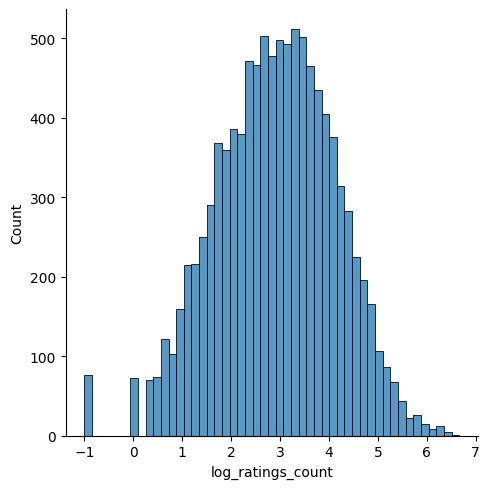

In [114]:
sns.displot(df.log_ratings_count)

In [115]:
# Define the bins using logarithmic scale
# since the distribution of the ratings_count_updt column is highly skewed, 
# using logarithmic bins is a good choice for creating more evenly distributed categories.
bins = [-1, np.log10(10), np.log10(100), np.log10(1000), np.log10(10000), np.log10(100000), np.inf]

In [116]:
# Define the labels for each category
labels = ['very low', 'low', 'medium', 'medium high', 'high', 'very high']

In [117]:
# Use pandas cut() function to categorize the values creating a new column with the category labels based on the log_ratings_count_updt column
df['ratings_count_category'] = pd.cut(df['log_ratings_count'], bins=bins, labels=labels)

In [118]:
df['ratings_count_category'].value_counts()

medium high    3002
medium         2905
low            1817
high           1610
very low        549
very high       352
Name: ratings_count_category, dtype: int64

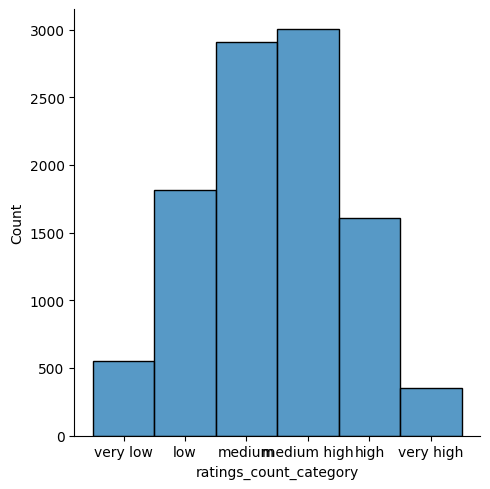

In [119]:
sns.displot(df.ratings_count_category)

In [120]:
# other different bin sizes tried
# bins2 = [-1, np.log10(100), np.log10(1000), np.log10(10000), np.log10(100000), np.log10(1000000), np.inf]
# medium         3002
# low            2905
# very low       2366
# medium high    1610
# high            322
# very high        30

# bins3 = [-np.inf, np.log10(100), np.log10(1000), np.log10(10000), np.log10(100000), np.log10(1000000), np.inf]
# medium         3002
# low            2905
# very low       2442
# medium high    1610
# high            322
# very high        30

In [121]:
# from categorical categories to numerical categories
# Use same function to map the values (set_value)
 
# Create the dictionary that assigns a number to each category
ratingscat_dictionary ={'very low' : 1, 'low' : 2, 'medium' : 3, 'medium high' : 4, 'high' : 5, 'very high' : 6}
 
# Add a new column named 'ratings_count_category_T'
df['ratings_count_category_T'] = df['ratings_count_category'].apply(set_value, args =(ratingscat_dictionary, ))

In [122]:
df.head()

,bookid,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher,authors_list,main_author,nb_authors,multiple_authors,ratings_count_updt,text_reviews_count_updt,max_pages,pub_month,pub_year,season,season_num,language_code_ENgroup,log_ratings_count,ratings_count_category,ratings_count_category_T
624,2034,comoediae 1: acharenses/equites/nubes/vespae/p...,aristophanes/f.w. hall/w.m. geldart,5.0,0198145047,9780198145042,grc,364,0,0,1922-02-22,oxford university press usa,"[aristophanes, f.w. hall, w.m. geldart]",aristophanes,3,1.0,0,0,364,2,1922,winter,1,grc,-1.000000,NaN,NaN
9893,39829,his princess devotional: a royal encounter wit...,sheri rose shepherd,5.0,1590529626,9781590529621,eng,240,2,0,2007-10-16,multnomah,[sheri rose shepherd],sheri rose shepherd,1,0.0,2,0,240,10,2007,autumn,4,eng,0.322219,very low,1
4788,17224,the diamond color meditation: color pathway to...,john diamond,5.0,1890995525,9781890995522,eng,74,5,3,2006-02-01,square one publishers,[john diamond],john diamond,1,0.0,5,3,74,2,2006,winter,1,eng,0.707570,very low,1
9324,36853,tyrannosaurus wrecks (stanley #1),laura driscoll/alisa klayman-grodsky/eric ...,5.0,0786845031,9780786845033,eng,24,2,1,2003-02-01,disney press,"[laura driscoll, alisa klayman-grodsky, eric ...",laura driscoll,3,1.0,2,1,24,2,2003,winter,1,eng,0.322219,very low,1
9720,38804,the irish anatomist: a study of flann o'brien,keith donohue,5.0,1930901356,9781930901353,eng,222,1,0,2003-07-25,academica press,[keith donohue],keith donohue,1,0.0,1,0,222,7,2003,summer,3,eng,0.041393,very low,1


In [123]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10311 entries, 624 to 10497
Data columns (total 27 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   bookid                    10311 non-null  int64         
 1   title                     10311 non-null  object        
 2   authors                   10311 non-null  object        
 3   average_rating            10311 non-null  float64       
 4   isbn                      10311 non-null  object        
 5   isbn13                    10311 non-null  int64         
 6   language_code             10311 non-null  object        
 7   num_pages                 10311 non-null  int64         
 8   ratings_count             10311 non-null  int64         
 9   text_reviews_count        10311 non-null  int64         
 10  publication_date          10311 non-null  datetime64[ns]
 11  publisher                 10311 non-null  object        
 12  authors_list    

###### Transform categoricals variable into numerical
- 2. Language, author and publisher -> Transform in numerical data

In [125]:
df['main_author'].value_counts().shape


(4188,)

In [147]:
# transform categorical variables into numerical variables with map and dictionary assigning random integers to avoid creating ordinal relationships

# create dictionary of values to random integer mapping
value_map = {value: np.random.randint(100000) for value in df['main_author'].unique()}

# use map method to apply the mapping to the column
df['main_author_T'] = df['main_author'].map(value_map)

df.head()

,bookid,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher,multiple_authors,n_authors,main_author38,ratings_count_updt,text_reviews_count_updt,max_pages,pub_month,pub_year,season,season_num,century,language_code_ENgroup,log_ratings_count,ratings_count_category,ratings_count_category_T,main_author_T
624,2034,comoediae 1: acharenses/equites/nubes/vespae/p...,aristophanes/f.w. hall/w.m. geldart,5.0,0198145047,9780198145042,grc,364,0,0,1922-02-22,oxford university press usa,1,3,aristophanes,0,0,364,2,1922,winter,1,19,grc,-1.000000,NaN,NaN,95715
9893,39829,his princess devotional: a royal encounter wit...,sheri rose shepherd,5.0,1590529626,9781590529621,eng,240,2,0,2007-10-16,multnomah,0,1,sheri rose shepherd,2,0,240,10,2007,autumn,4,20,eng,0.322219,very low,1,20156
4788,17224,the diamond color meditation: color pathway to...,john diamond,5.0,1890995525,9781890995522,eng,74,5,3,2006-02-01,square one publishers,0,1,john diamond,5,3,74,2,2006,winter,1,20,eng,0.707570,very low,1,71416
9324,36853,tyrannosaurus wrecks (stanley #1),laura driscoll/alisa klayman-grodsky/eric ...,5.0,0786845031,9780786845033,eng,24,2,1,2003-02-01,disney press,1,3,laura driscoll,2,1,24,2,2003,winter,1,20,eng,0.322219,very low,1,77967
9720,38804,the irish anatomist: a study of flann o'brien,keith donohue,5.0,1930901356,9781930901353,eng,222,1,0,2003-07-25,academica press,0,1,keith donohue,1,0,222,7,2003,summer,3,20,eng,0.041393,very low,1,18724


In [148]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10311 entries, 624 to 10497
Data columns (total 28 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   bookid                    10311 non-null  int64         
 1   title                     10311 non-null  object        
 2   authors                   10311 non-null  object        
 3   average_rating            10311 non-null  float64       
 4   isbn                      10311 non-null  object        
 5   isbn13                    10311 non-null  int64         
 6   language_code             10311 non-null  object        
 7   num_pages                 10311 non-null  int64         
 8   ratings_count             10311 non-null  int64         
 9   text_reviews_count        10311 non-null  int64         
 10  publication_date          10311 non-null  datetime64[ns]
 11  publisher                 10311 non-null  object        
 12  multiple_authors

In [149]:
df['publisher'].value_counts().shape


(2184,)

In [150]:
# transform categorical variables into numerical variables with map and dictionary assigning random integers to avoid creating ordinal relationships

# create dictionary of values to random integer mapping
value_map = {value: np.random.randint(100000) for value in df['publisher'].unique()}

# use map method to apply the mapping to the column
df['publisher_T'] = df['publisher'].map(value_map)

df.head()

,bookid,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher,multiple_authors,n_authors,main_author38,ratings_count_updt,text_reviews_count_updt,max_pages,pub_month,pub_year,season,season_num,century,language_code_ENgroup,log_ratings_count,ratings_count_category,ratings_count_category_T,main_author_T,publisher_T
624,2034,comoediae 1: acharenses/equites/nubes/vespae/p...,aristophanes/f.w. hall/w.m. geldart,5.0,0198145047,9780198145042,grc,364,0,0,1922-02-22,oxford university press usa,1,3,aristophanes,0,0,364,2,1922,winter,1,19,grc,-1.000000,NaN,NaN,95715,80039
9893,39829,his princess devotional: a royal encounter wit...,sheri rose shepherd,5.0,1590529626,9781590529621,eng,240,2,0,2007-10-16,multnomah,0,1,sheri rose shepherd,2,0,240,10,2007,autumn,4,20,eng,0.322219,very low,1,20156,70562
4788,17224,the diamond color meditation: color pathway to...,john diamond,5.0,1890995525,9781890995522,eng,74,5,3,2006-02-01,square one publishers,0,1,john diamond,5,3,74,2,2006,winter,1,20,eng,0.707570,very low,1,71416,70252
9324,36853,tyrannosaurus wrecks (stanley #1),laura driscoll/alisa klayman-grodsky/eric ...,5.0,0786845031,9780786845033,eng,24,2,1,2003-02-01,disney press,1,3,laura driscoll,2,1,24,2,2003,winter,1,20,eng,0.322219,very low,1,77967,24132
9720,38804,the irish anatomist: a study of flann o'brien,keith donohue,5.0,1930901356,9781930901353,eng,222,1,0,2003-07-25,academica press,0,1,keith donohue,1,0,222,7,2003,summer,3,20,eng,0.041393,very low,1,18724,82446


In [151]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10311 entries, 624 to 10497
Data columns (total 29 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   bookid                    10311 non-null  int64         
 1   title                     10311 non-null  object        
 2   authors                   10311 non-null  object        
 3   average_rating            10311 non-null  float64       
 4   isbn                      10311 non-null  object        
 5   isbn13                    10311 non-null  int64         
 6   language_code             10311 non-null  object        
 7   num_pages                 10311 non-null  int64         
 8   ratings_count             10311 non-null  int64         
 9   text_reviews_count        10311 non-null  int64         
 10  publication_date          10311 non-null  datetime64[ns]
 11  publisher                 10311 non-null  object        
 12  multiple_authors

In [152]:
df['language_code'].value_counts().shape

(26,)

In [153]:
# transform categorical variables into numerical variables with map and dictionary assigning random integers to avoid creating ordinal relationships

# create dictionary of values to random integer mapping
value_map = {value: np.random.randint(100000) for value in df['language_code'].unique()}

# use map method to apply the mapping to the column
df['language_code_T'] = df['language_code'].map(value_map)

df.head()

,bookid,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher,multiple_authors,n_authors,main_author38,ratings_count_updt,text_reviews_count_updt,max_pages,pub_month,pub_year,season,season_num,century,language_code_ENgroup,log_ratings_count,ratings_count_category,ratings_count_category_T,main_author_T,publisher_T,language_code_T
624,2034,comoediae 1: acharenses/equites/nubes/vespae/p...,aristophanes/f.w. hall/w.m. geldart,5.0,0198145047,9780198145042,grc,364,0,0,1922-02-22,oxford university press usa,1,3,aristophanes,0,0,364,2,1922,winter,1,19,grc,-1.000000,NaN,NaN,95715,80039,99145
9893,39829,his princess devotional: a royal encounter wit...,sheri rose shepherd,5.0,1590529626,9781590529621,eng,240,2,0,2007-10-16,multnomah,0,1,sheri rose shepherd,2,0,240,10,2007,autumn,4,20,eng,0.322219,very low,1,20156,70562,2507
4788,17224,the diamond color meditation: color pathway to...,john diamond,5.0,1890995525,9781890995522,eng,74,5,3,2006-02-01,square one publishers,0,1,john diamond,5,3,74,2,2006,winter,1,20,eng,0.707570,very low,1,71416,70252,2507
9324,36853,tyrannosaurus wrecks (stanley #1),laura driscoll/alisa klayman-grodsky/eric ...,5.0,0786845031,9780786845033,eng,24,2,1,2003-02-01,disney press,1,3,laura driscoll,2,1,24,2,2003,winter,1,20,eng,0.322219,very low,1,77967,24132,2507
9720,38804,the irish anatomist: a study of flann o'brien,keith donohue,5.0,1930901356,9781930901353,eng,222,1,0,2003-07-25,academica press,0,1,keith donohue,1,0,222,7,2003,summer,3,20,eng,0.041393,very low,1,18724,82446,2507


In [154]:
df.info() #why null values when creating the categories ?

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10311 entries, 624 to 10497
Data columns (total 30 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   bookid                    10311 non-null  int64         
 1   title                     10311 non-null  object        
 2   authors                   10311 non-null  object        
 3   average_rating            10311 non-null  float64       
 4   isbn                      10311 non-null  object        
 5   isbn13                    10311 non-null  int64         
 6   language_code             10311 non-null  object        
 7   num_pages                 10311 non-null  int64         
 8   ratings_count             10311 non-null  int64         
 9   text_reviews_count        10311 non-null  int64         
 10  publication_date          10311 non-null  datetime64[ns]
 11  publisher                 10311 non-null  object        
 12  multiple_authors

In [126]:
# transform categorical variables into numerical variables with map and dictionary assigning random integers to avoid creating ordinal relationships

# create dictionary of values to random integer mapping
value_map = {value: np.random.randint(100000) for value in df['language_code_ENgroup'].unique()}

# use map method to apply the mapping to the column
df['language_code_ENgroup_T'] = df['language_code_ENgroup'].map(value_map)

df.head()

,bookid,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher,authors_list,main_author,nb_authors,multiple_authors,ratings_count_updt,text_reviews_count_updt,max_pages,pub_month,pub_year,season,season_num,language_code_ENgroup,log_ratings_count,ratings_count_category,ratings_count_category_T,language_code_ENgroup_T
624,2034,comoediae 1: acharenses/equites/nubes/vespae/p...,aristophanes/f.w. hall/w.m. geldart,5.0,0198145047,9780198145042,grc,364,0,0,1922-02-22,oxford university press usa,"[aristophanes, f.w. hall, w.m. geldart]",aristophanes,3,1.0,0,0,364,2,1922,winter,1,grc,-1.000000,NaN,NaN,50493
9893,39829,his princess devotional: a royal encounter wit...,sheri rose shepherd,5.0,1590529626,9781590529621,eng,240,2,0,2007-10-16,multnomah,[sheri rose shepherd],sheri rose shepherd,1,0.0,2,0,240,10,2007,autumn,4,eng,0.322219,very low,1,62402
4788,17224,the diamond color meditation: color pathway to...,john diamond,5.0,1890995525,9781890995522,eng,74,5,3,2006-02-01,square one publishers,[john diamond],john diamond,1,0.0,5,3,74,2,2006,winter,1,eng,0.707570,very low,1,62402
9324,36853,tyrannosaurus wrecks (stanley #1),laura driscoll/alisa klayman-grodsky/eric ...,5.0,0786845031,9780786845033,eng,24,2,1,2003-02-01,disney press,"[laura driscoll, alisa klayman-grodsky, eric ...",laura driscoll,3,1.0,2,1,24,2,2003,winter,1,eng,0.322219,very low,1,62402
9720,38804,the irish anatomist: a study of flann o'brien,keith donohue,5.0,1930901356,9781930901353,eng,222,1,0,2003-07-25,academica press,[keith donohue],keith donohue,1,0.0,1,0,222,7,2003,summer,3,eng,0.041393,very low,1,62402


In [127]:
df[['main_author','main_author_T','publisher','publisher_T','language_code','language_code_T','language_code_ENgroup','language_code_ENgroup_T']].head()

KeyError: "['main_author_T', 'publisher_T', 'language_code_T'] not in index"

In [128]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10311 entries, 624 to 10497
Data columns (total 28 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   bookid                    10311 non-null  int64         
 1   title                     10311 non-null  object        
 2   authors                   10311 non-null  object        
 3   average_rating            10311 non-null  float64       
 4   isbn                      10311 non-null  object        
 5   isbn13                    10311 non-null  int64         
 6   language_code             10311 non-null  object        
 7   num_pages                 10311 non-null  int64         
 8   ratings_count             10311 non-null  int64         
 9   text_reviews_count        10311 non-null  int64         
 10  publication_date          10311 non-null  datetime64[ns]
 11  publisher                 10311 non-null  object        
 12  authors_list    

###### Transform num_pages & max_pages
- 3. Transform num pages into category (low, medium, high) -> classic spliting 

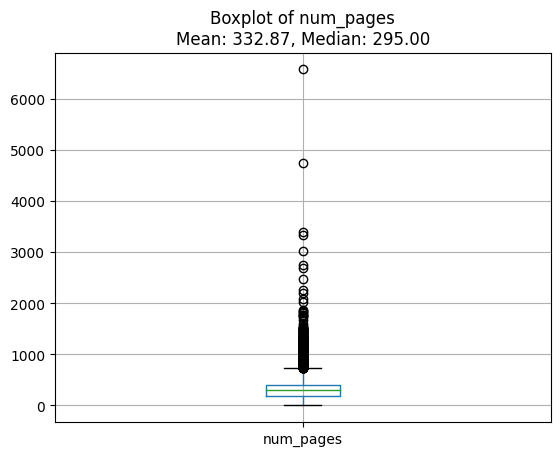

In [129]:
# Compute the mean and median values for the 'num_pages' column
mean_value = df['num_pages'].mean()
median_value = df['num_pages'].median()

# Plot a boxplot for the 'num_pages' column
ax = df.boxplot(column='num_pages')
ax.set_title('Boxplot of num_pages\nMean: {:.2f}, Median: {:.2f}'.format(mean_value, median_value))
plt.show()

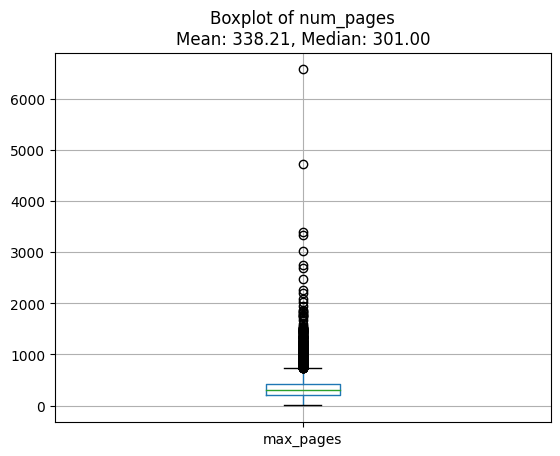

In [130]:
# Compute the mean and median values for the 'max_pages' column
mean_value = df['max_pages'].mean()
median_value = df['max_pages'].median()

# Plot a boxplot for the 'max_pages' column
ay = df.boxplot(column='max_pages')
ay.set_title('Boxplot of num_pages\nMean: {:.2f}, Median: {:.2f}'.format(mean_value, median_value))
plt.show()

In [131]:
# Define the bin ranges for the categories
bins = [0, 50, 200, 400, 1000, float('inf')]

# Define the labels for the categories
labels = ['very low', 'low', 'medium', 'high', 'very high']

# Use the cut() function to convert the numerical values into categories
df['num_pages_cat'] = pd.cut(df['num_pages'], bins=bins, labels=labels)
df['max_pages_cat'] = pd.cut(df['max_pages'], bins=bins, labels=labels)

In [132]:
df['num_pages_cat'].value_counts()

medium       4870
high         2498
low          2246
very low      442
very high     186
Name: num_pages_cat, dtype: int64

In [133]:
df['max_pages_cat'].value_counts()

medium       4912
high         2557
low          2230
very low      419
very high     193
Name: max_pages_cat, dtype: int64

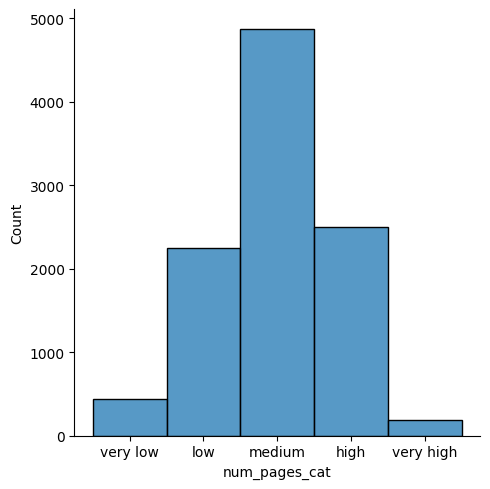

In [134]:
sns.displot(df.num_pages_cat)

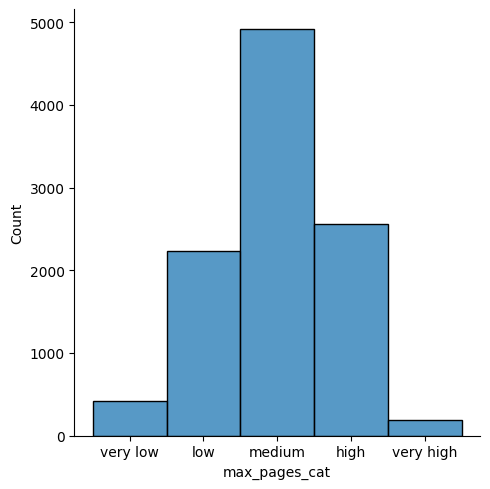

In [135]:
sns.displot(df.max_pages_cat)

In [136]:
# from categorical categories to numerical categories
# Use same function to map the values (set_value)
 
# Create the dictionary that assigns a number to each category
numpagcat_dictionary ={'very low' : 1, 'low' : 2, 'medium' : 3, 'high' : 4, 'very high' : 5}
 
# Add a new column named 'num_pages_cat_T'
df['num_pages_cat_T'] = df['num_pages_cat'].apply(set_value, args =(numpagcat_dictionary, ))

In [137]:
# from categorical categories to numerical categories
# Use same function to map the values (set_value)
 
# Create the dictionary that assigns a number to each category
maxpagcat_dictionary ={'very low' : 1, 'low' : 2, 'medium' : 3, 'high' : 4, 'very high' : 5}
 
# Add a new column named 'max_pages_cat_T'
df['max_pages_cat_T'] = df['max_pages_cat'].apply(set_value, args =(maxpagcat_dictionary, ))

In [138]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10311 entries, 624 to 10497
Data columns (total 32 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   bookid                    10311 non-null  int64         
 1   title                     10311 non-null  object        
 2   authors                   10311 non-null  object        
 3   average_rating            10311 non-null  float64       
 4   isbn                      10311 non-null  object        
 5   isbn13                    10311 non-null  int64         
 6   language_code             10311 non-null  object        
 7   num_pages                 10311 non-null  int64         
 8   ratings_count             10311 non-null  int64         
 9   text_reviews_count        10311 non-null  int64         
 10  publication_date          10311 non-null  datetime64[ns]
 11  publisher                 10311 non-null  object        
 12  authors_list    

###### Trasform rating 
- 4. Transform rating into category (bad, medium, good) -> log function (important data : 91% of data between 3,5 and 4,4, lloks like a normal law)

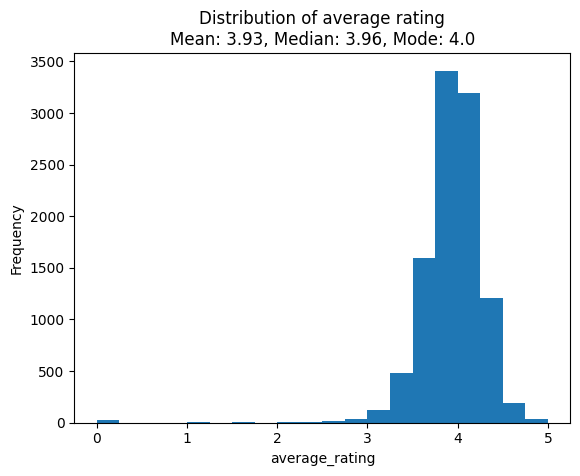

In [139]:
# Plot the distribution of the 'rating' column using a log function
mean_value = df['average_rating'].mean()
median_value = df['average_rating'].median()
mode_value = df['average_rating'].mode()
plt.hist((df['average_rating']), bins=20)
plt.xlabel('average_rating')
plt.ylabel('Frequency')
plt.title('Distribution of average rating\nMean: {:.2f}, Median: {:.2f}, Mode: 4.0'.format(mean_value, median_value))

plt.show()
# mean < median < mode Left Skewed Distribution

In [140]:
# Define the bin ranges for the categories
bins = [0, 1, 2, 3, 4, 5]

# Define the labels for the categories
labels = ['very bad','bad', 'medium', 'good', 'very good']

#I would like 'very good' to be just for df['average_rating']==5 and very bad df['average_rating']==0 and the rest equally distributed

# Use the cut() function to convert the numerical values into categories
df['average_rating_cat'] = pd.cut(df['average_rating'], bins=bins, labels=labels)

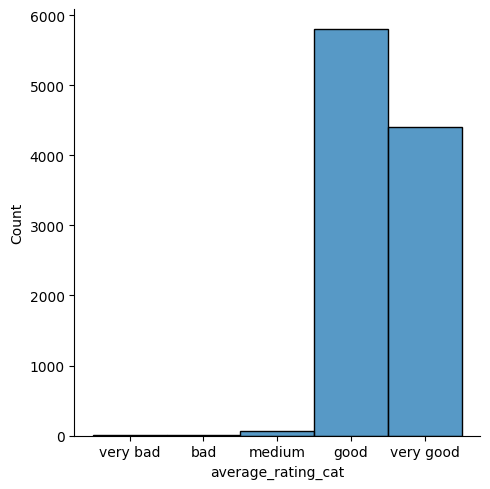

In [141]:
sns.displot(df.average_rating_cat)

In [142]:
# from categorical categories to numerical categories
# Use same function to map the values (set_value)
 
# Create the dictionary that assigns a number to each category
ratingscat_dictionary ={'very bad' : 1, 'bad' : 2, 'medium' : 3, 'good' : 4, 'very good' : 5}
 
# Add a new column named 'average_rating_cat_T'
df['average_rating_cat_T'] = df['average_rating_cat'].apply(set_value, args =(ratingscat_dictionary, ))

In [143]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10311 entries, 624 to 10497
Data columns (total 34 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   bookid                    10311 non-null  int64         
 1   title                     10311 non-null  object        
 2   authors                   10311 non-null  object        
 3   average_rating            10311 non-null  float64       
 4   isbn                      10311 non-null  object        
 5   isbn13                    10311 non-null  int64         
 6   language_code             10311 non-null  object        
 7   num_pages                 10311 non-null  int64         
 8   ratings_count             10311 non-null  int64         
 9   text_reviews_count        10311 non-null  int64         
 10  publication_date          10311 non-null  datetime64[ns]
 11  publisher                 10311 non-null  object        
 12  authors_list    

#### Dataset Analysis
- DESCRIBE DATA
- ANALYSIS PART - Create a column average of rating vote -> average by author (keep this one but demonstrate we thought about the other option)	ponderate average by nb of votes

- ISBN13 et 10 -> Find a table equivalent for region/ country	

- AT THE END - Useless column (idbook) -> Delete
- AT THE END - Remove other useless or redundant colums
- AT THE END - Change the order of the columns of the table putting at the beginning those that are the key for prediction purposes then other columns by importance


###### Inspecting the original dataset
- 1. Describe Data

In [173]:
df.columns

Index(['bookid', 'title', 'authors', 'average_rating', 'isbn', 'isbn13', 'language_code', 'num_pages', 'ratings_count', 'text_reviews_count', 'publication_date', 'publisher', 'multiple_authors', 'n_authors', 'main_author38', 'ratings_count_updt', 'text_reviews_count_updt', 'max_pages', 'pub_month', 'pub_year', 'season', 'season_num', 'century', 'language_code_ENgroup', 'log_ratings_count', 'ratings_count_category', 'ratings_count_category_T', 'main_author_T', 'publisher_T', 'language_code_T', 'language_code_ENgroup_T', 'num_pages_cat', 'max_pages_cat', 'num_pages_cat_T', 'max_pages_cat_T', 'average_rating_cat', 'average_rating_cat_T'], dtype='object')

In [174]:
df1 = df.copy()

In [175]:
df1 = df1.drop(['bookid', 'title', 'authors', 'isbn', 'isbn13'], axis=1)

In [176]:
df1.columns

Index(['average_rating', 'language_code', 'num_pages', 'ratings_count', 'text_reviews_count', 'publication_date', 'publisher', 'multiple_authors', 'n_authors', 'main_author38', 'ratings_count_updt', 'text_reviews_count_updt', 'max_pages', 'pub_month', 'pub_year', 'season', 'season_num', 'century', 'language_code_ENgroup', 'log_ratings_count', 'ratings_count_category', 'ratings_count_category_T', 'main_author_T', 'publisher_T', 'language_code_T', 'language_code_ENgroup_T', 'num_pages_cat', 'max_pages_cat', 'num_pages_cat_T', 'max_pages_cat_T', 'average_rating_cat', 'average_rating_cat_T'], dtype='object')

In [177]:
# Define the order of the columns
new_order = ['main_author38',  'main_author_T','multiple_authors', 'n_authors',
             'average_rating', 'average_rating_cat', 'average_rating_cat_T',
             'ratings_count', 'ratings_count_updt', 'log_ratings_count','ratings_count_category','ratings_count_category_T',
             'text_reviews_count','text_reviews_count_updt',
             'language_code','language_code_T',
             'language_code_ENgroup', 'language_code_ENgroup_T',
             'num_pages','num_pages_cat','num_pages_cat_T',
             'max_pages', 'max_pages_cat', 'max_pages_cat_T',
             'publication_date', 'pub_month', 'pub_year', 'season', 'season_num', 'century',
             'publisher', 'publisher_T'
             ]

# Use the reindex method to reorder the columns
df1 = df1.reindex(columns=new_order)

In [178]:
df1.info() 
# ratings_count_category 10235
# ratings_count_category_T  10235
# num_pages_cat             10242
# num_pages_cat_T             10242
# average_rating_cat        10286
# average_rating_cat_T        10286
#
#
#

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10311 entries, 624 to 10497
Data columns (total 32 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   main_author38             10311 non-null  object        
 1   main_author_T             10311 non-null  int64         
 2   multiple_authors          10311 non-null  int32         
 3   n_authors                 10311 non-null  int64         
 4   average_rating            10311 non-null  float64       
 5   average_rating_cat        10286 non-null  category      
 6   average_rating_cat_T      10286 non-null  category      
 7   ratings_count             10311 non-null  int64         
 8   ratings_count_updt        10311 non-null  int64         
 9   log_ratings_count         10311 non-null  float64       
 10  ratings_count_category    10235 non-null  category      
 11  ratings_count_category_T  10235 non-null  category      
 12  text_reviews_cou

In [179]:
df1.sample(1)

,main_author38,main_author_T,multiple_authors,n_authors,average_rating,average_rating_cat,average_rating_cat_T,ratings_count,ratings_count_updt,log_ratings_count,ratings_count_category,ratings_count_category_T,text_reviews_count,text_reviews_count_updt,language_code,language_code_T,language_code_ENgroup,language_code_ENgroup_T,num_pages,num_pages_cat,num_pages_cat_T,max_pages,max_pages_cat,max_pages_cat_T,publication_date,pub_month,pub_year,season,season_num,century,publisher,publisher_T
7777,isaac asimov,66770,0,1,4.36,very good,5,5362,5362,3.729335,medium high,4,115,115,eng,2507,eng,34954,624,high,4,624,high,4,1990-10-01,10,1990,autumn,4,19,broadway,42725


In [180]:
df1.columns

Index(['main_author38', 'main_author_T', 'multiple_authors', 'n_authors', 'average_rating', 'average_rating_cat', 'average_rating_cat_T', 'ratings_count', 'ratings_count_updt', 'log_ratings_count', 'ratings_count_category', 'ratings_count_category_T', 'text_reviews_count', 'text_reviews_count_updt', 'language_code', 'language_code_T', 'language_code_ENgroup', 'language_code_ENgroup_T', 'num_pages', 'num_pages_cat', 'num_pages_cat_T', 'max_pages', 'max_pages_cat', 'max_pages_cat_T', 'publication_date', 'pub_month', 'pub_year', 'season', 'season_num', 'century', 'publisher', 'publisher_T'], dtype='object')

In [181]:
# describing columns with categorical values (not considering title since it is just identifier)
df1[['main_author38', 'average_rating_cat','ratings_count_category', 'language_code', 'language_code_ENgroup', 'num_pages_cat', 'max_pages_cat','season', 'publisher']].describe()

,main_author38,average_rating_cat,ratings_count_category,language_code,language_code_ENgroup,num_pages_cat,max_pages_cat,season,publisher
count,10311,10286,10235,10311,10311,10242,10311,10311,10311
unique,4189,5,6,26,23,5,5,4,2184
top,stephen king,good,medium high,eng,eng,medium,medium,autumn,vintage
freq,62,5799,3002,8240,9759,4870,4912,3114,292


In [182]:
# describing columns with numerical values (not considering bookid, isbn, isbn13 since they are just identifiers)
df1[['main_author_T', 'multiple_authors', 'n_authors', 'average_rating', 'average_rating_cat_T', 'ratings_count', 'ratings_count_updt', 'log_ratings_count', 'ratings_count_category_T', 'text_reviews_count', 'text_reviews_count_updt', 'language_code_T', 'language_code_ENgroup_T', 'num_pages', 'num_pages_cat_T', 'max_pages', 'max_pages_cat_T', 'publication_date', 'pub_month', 'pub_year', 'season_num', 'century', 'publisher_T']].describe()
# look at the min row there are many variables with value=0 
# go deep to find if that brings bad consequences to our dataset

,main_author_T,multiple_authors,n_authors,average_rating,ratings_count,ratings_count_updt,log_ratings_count,text_reviews_count,text_reviews_count_updt,language_code_T,language_code_ENgroup_T,num_pages,max_pages,pub_month,pub_year,season_num,century,publisher_T
count,10311.000000,10311.000000,10311.000000,10311.000000,1.031100e+04,1.031100e+04,10311.000000,10311.000000,10311.000000,10311.000000,10311.000000,10311.000000,10311.000000,10311.000000,10311.000000,10311.000000,10311.000000,10311.000000
mean,50511.056542,0.399088,1.715643,3.933916,1.514625e+04,1.935586e+04,2.897515,486.816701,584.734846,10319.910678,34829.635050,332.871593,338.213461,6.561730,2000.172534,2.602560,19.689652,51310.248085
std,28579.336121,0.489735,1.844126,0.357207,9.777008e+04,1.172368e+05,1.223515,2361.552322,2694.227920,18481.599456,6478.051762,238.671765,239.255716,3.412967,8.235124,1.138826,0.462659,27981.929586
min,43.000000,0.000000,1.000000,0.000000,0.000000e+00,0.000000e+00,-1.000000,0.000000,0.000000,1048.000000,488.000000,0.000000,1.000000,1.000000,1900.000000,1.000000,19.000000,11.000000
25%,25385.000000,0.000000,1.000000,3.770000,1.030000e+02,1.120000e+02,2.049606,9.000000,9.000000,2507.000000,34954.000000,192.000000,198.000000,4.000000,1998.000000,2.000000,19.000000,28131.000000
50%,50545.000000,0.000000,1.000000,3.960000,7.620000e+02,8.730000e+02,2.941064,46.000000,51.000000,2507.000000,34954.000000,295.000000,301.000000,7.000000,2003.000000,3.000000,20.000000,48430.000000
75%,75333.000000,1.000000,2.000000,4.140000,5.029000e+03,5.832500e+03,3.765862,232.000000,266.000000,2507.000000,34954.000000,409.000000,416.000000,10.000000,2005.000000,4.000000,20.000000,76034.000000
max,99954.000000,1.000000,51.000000,5.000000,4.597666e+06,4.597666e+06,6.662537,94265.000000,94265.000000,99145.000000,89563.000000,6576.000000,6576.000000,12.000000,2020.000000,4.000000,20.000000,99996.000000


In [183]:
# many values = 0 in many columns, inspecting them

In [184]:
# display the rows rows which may present the issue
df[(df.T == 0).any()]
# 6518 rows have at least 1 column with at least 1 observation = 0

,bookid,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher,multiple_authors,n_authors,main_author38,ratings_count_updt,text_reviews_count_updt,max_pages,pub_month,pub_year,season,season_num,century,language_code_ENgroup,log_ratings_count,ratings_count_category,ratings_count_category_T,main_author_T,publisher_T,language_code_T,language_code_ENgroup_T,num_pages_cat,max_pages_cat,num_pages_cat_T,max_pages_cat_T,average_rating_cat,average_rating_cat_T
624,2034,comoediae 1: acharenses/equites/nubes/vespae/p...,aristophanes/f.w. hall/w.m. geldart,5.0,0198145047,9780198145042,grc,364,0,0,1922-02-22,oxford university press usa,1,3,aristophanes,0,0,364,2,1922,winter,1,19,grc,-1.000000,NaN,NaN,95715,80039,99145,44447,medium,medium,3,3,very good,5
9893,39829,his princess devotional: a royal encounter wit...,sheri rose shepherd,5.0,1590529626,9781590529621,eng,240,2,0,2007-10-16,multnomah,0,1,sheri rose shepherd,2,0,240,10,2007,autumn,4,20,eng,0.322219,very low,1,20156,70562,2507,34954,medium,medium,3,3,very good,5
4788,17224,the diamond color meditation: color pathway to...,john diamond,5.0,1890995525,9781890995522,eng,74,5,3,2006-02-01,square one publishers,0,1,john diamond,5,3,74,2,2006,winter,1,20,eng,0.707570,very low,1,71416,70252,2507,34954,low,low,2,2,very good,5
9720,38804,the irish anatomist: a study of flann o'brien,keith donohue,5.0,1930901356,9781930901353,eng,222,1,0,2003-07-25,academica press,0,1,keith donohue,1,0,222,7,2003,summer,3,20,eng,0.041393,very low,1,18724,82446,2507,34954,medium,medium,3,3,very good,5
4933,17830,bulgakov's the master and margarita: the text ...,elena n. mahlow,5.0,0533017424,9780533017423,eng,202,4,0,1975-01-01,vantage press,0,1,elena n. mahlow,4,0,202,1,1975,winter,1,19,eng,0.612784,very low,1,74304,90489,2507,34954,medium,medium,3,3,very good,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6877,25903,i'll be home before midnight and i won't get p...,anthony e. wolf,0.0,0394755669,9780394755663,eng,288,0,0,1988-05-12,knopf doubleday publishing group,0,1,anthony e. wolf,0,0,288,5,1988,spring,2,19,eng,-1.000000,NaN,NaN,1102,33842,2507,34954,medium,medium,3,3,NaN,NaN
3492,12712,brodie's notes on aldous huxley's brave new world,graham handley,0.0,0333581296,9780333581292,eng,71,0,0,1992-08-20,macmillan,0,1,graham handley,0,0,71,8,1992,summer,3,19,eng,-1.000000,NaN,NaN,1107,66275,2507,34954,low,low,2,2,NaN,NaN
2533,9338,insights: talks on the nature of existence,frederick p. lenz,0.0,1932206086,9781932206081,eng,304,0,0,2003-01-01,frederick p. lenz foundation for american budd...,0,1,frederick p. lenz,0,0,304,1,2003,winter,1,20,eng,-1.000000,NaN,NaN,42978,11451,2507,34954,medium,medium,3,3,NaN,NaN
2532,9337,how to meditate: an anthology of talks on medi...,frederick p. lenz,0.0,1932206108,9781932206104,eng,228,0,0,2004-01-01,frederick p. lenz foundation for american budd...,0,1,frederick p. lenz,0,0,228,1,2004,winter,1,20,eng,-1.000000,NaN,NaN,42978,11451,2507,34954,medium,medium,3,3,NaN,NaN


In [185]:
numerical = df1[['main_author_T', 'multiple_authors', 'n_authors', 'average_rating', 'average_rating_cat_T', 'ratings_count', 'ratings_count_updt', 'log_ratings_count', 'ratings_count_category_T', 'text_reviews_count', 'text_reviews_count_updt', 'language_code_T', 'language_code_ENgroup_T', 'num_pages', 'num_pages_cat_T', 'max_pages', 'max_pages_cat_T', 'publication_date', 'pub_month', 'pub_year', 'season_num', 'century', 'publisher_T']]
categorical=df1[['main_author38', 'average_rating_cat','ratings_count_category', 'language_code', 'language_code_ENgroup', 'num_pages_cat', 'max_pages_cat','season', 'publisher']]

In [186]:
# displaying just the numerical column to have a clearer view
numerical[(df==0).any(1)]

,main_author_T,multiple_authors,n_authors,average_rating,average_rating_cat_T,ratings_count,ratings_count_updt,log_ratings_count,ratings_count_category_T,text_reviews_count,text_reviews_count_updt,language_code_T,language_code_ENgroup_T,num_pages,num_pages_cat_T,max_pages,max_pages_cat_T,publication_date,pub_month,pub_year,season_num,century,publisher_T
624,95715,1,3,5.0,5,0,0,-1.000000,NaN,0,0,99145,44447,364,3,364,3,1922-02-22,2,1922,1,19,80039
9893,20156,0,1,5.0,5,2,2,0.322219,1,0,0,2507,34954,240,3,240,3,2007-10-16,10,2007,4,20,70562
4788,71416,0,1,5.0,5,5,5,0.707570,1,3,3,2507,34954,74,2,74,2,2006-02-01,2,2006,1,20,70252
9720,18724,0,1,5.0,5,1,1,0.041393,1,0,0,2507,34954,222,3,222,3,2003-07-25,7,2003,3,20,82446
4933,74304,0,1,5.0,5,4,4,0.612784,1,0,0,2507,34954,202,3,202,3,1975-01-01,1,1975,1,19,90489
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6877,1102,0,1,0.0,NaN,0,0,-1.000000,NaN,0,0,2507,34954,288,3,288,3,1988-05-12,5,1988,2,19,33842
3492,1107,0,1,0.0,NaN,0,0,-1.000000,NaN,0,0,2507,34954,71,2,71,2,1992-08-20,8,1992,3,19,66275
2533,42978,0,1,0.0,NaN,0,0,-1.000000,NaN,0,0,2507,34954,304,3,304,3,2003-01-01,1,2003,1,20,11451
2532,42978,0,1,0.0,NaN,0,0,-1.000000,NaN,0,0,2507,34954,228,3,228,3,2004-01-01,1,2004,1,20,11451


In [187]:
# since our scope is predicting the rating we first look for 0 values just in ratings_count and text_reviews_count
df[['average_rating','max_pages','ratings_count_updt','text_reviews_count_updt']][(df[['ratings_count_updt','text_reviews_count_updt']]==0).any(1)]

,average_rating,max_pages,ratings_count_updt,text_reviews_count_updt
624,5.0,364,0,0
9893,5.0,240,2,0
9720,5.0,222,1,0
4933,5.0,202,4,0
6775,5.0,150,1,0
...,...,...,...,...
6877,0.0,288,0,0
3492,0.0,71,0,0
2533,0.0,304,0,0
2532,0.0,228,0,0


In [188]:
# what is the average rating when either ratings_count_updt or text_reviews_count_updt have 0 value ?

In [189]:
df[(df[['ratings_count_updt','text_reviews_count_updt']]==0).any(1)] # rows with 0 value in either ratings_count or text_reviews_count or both

,bookid,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher,multiple_authors,n_authors,main_author38,ratings_count_updt,text_reviews_count_updt,max_pages,pub_month,pub_year,season,season_num,century,language_code_ENgroup,log_ratings_count,ratings_count_category,ratings_count_category_T,main_author_T,publisher_T,language_code_T,language_code_ENgroup_T,num_pages_cat,max_pages_cat,num_pages_cat_T,max_pages_cat_T,average_rating_cat,average_rating_cat_T
624,2034,comoediae 1: acharenses/equites/nubes/vespae/p...,aristophanes/f.w. hall/w.m. geldart,5.0,0198145047,9780198145042,grc,364,0,0,1922-02-22,oxford university press usa,1,3,aristophanes,0,0,364,2,1922,winter,1,19,grc,-1.000000,NaN,NaN,95715,80039,99145,44447,medium,medium,3,3,very good,5
9893,39829,his princess devotional: a royal encounter wit...,sheri rose shepherd,5.0,1590529626,9781590529621,eng,240,2,0,2007-10-16,multnomah,0,1,sheri rose shepherd,2,0,240,10,2007,autumn,4,20,eng,0.322219,very low,1,20156,70562,2507,34954,medium,medium,3,3,very good,5
9720,38804,the irish anatomist: a study of flann o'brien,keith donohue,5.0,1930901356,9781930901353,eng,222,1,0,2003-07-25,academica press,0,1,keith donohue,1,0,222,7,2003,summer,3,20,eng,0.041393,very low,1,18724,82446,2507,34954,medium,medium,3,3,very good,5
4933,17830,bulgakov's the master and margarita: the text ...,elena n. mahlow,5.0,0533017424,9780533017423,eng,202,4,0,1975-01-01,vantage press,0,1,elena n. mahlow,4,0,202,1,1975,winter,1,19,eng,0.612784,very low,1,74304,90489,2507,34954,medium,medium,3,3,very good,5
6775,25426,delwau duon: peintiadau nicholas evans = symph...,nicholas evans/rhonda evans,5.0,0862431352,9780862431358,wel,150,1,0,1987-06-22,y lolfa,1,2,nicholas evans,1,0,150,6,1987,summer,3,19,wel,0.041393,very low,1,8363,33275,56975,89563,low,low,2,2,very good,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6877,25903,i'll be home before midnight and i won't get p...,anthony e. wolf,0.0,0394755669,9780394755663,eng,288,0,0,1988-05-12,knopf doubleday publishing group,0,1,anthony e. wolf,0,0,288,5,1988,spring,2,19,eng,-1.000000,NaN,NaN,1102,33842,2507,34954,medium,medium,3,3,NaN,NaN
3492,12712,brodie's notes on aldous huxley's brave new world,graham handley,0.0,0333581296,9780333581292,eng,71,0,0,1992-08-20,macmillan,0,1,graham handley,0,0,71,8,1992,summer,3,19,eng,-1.000000,NaN,NaN,1107,66275,2507,34954,low,low,2,2,NaN,NaN
2533,9338,insights: talks on the nature of existence,frederick p. lenz,0.0,1932206086,9781932206081,eng,304,0,0,2003-01-01,frederick p. lenz foundation for american budd...,0,1,frederick p. lenz,0,0,304,1,2003,winter,1,20,eng,-1.000000,NaN,NaN,42978,11451,2507,34954,medium,medium,3,3,NaN,NaN
2532,9337,how to meditate: an anthology of talks on medi...,frederick p. lenz,0.0,1932206108,9781932206104,eng,228,0,0,2004-01-01,frederick p. lenz foundation for american budd...,0,1,frederick p. lenz,0,0,228,1,2004,winter,1,20,eng,-1.000000,NaN,NaN,42978,11451,2507,34954,medium,medium,3,3,NaN,NaN


###### Sorting data according to different columns

In [190]:
# Sort dataset by average rating
df_sort_rating=df.sort_values('average_rating', ascending=False)
df_sort_rating.head()
df_sort_rating.tail()

,bookid,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher,multiple_authors,n_authors,main_author38,ratings_count_updt,text_reviews_count_updt,max_pages,pub_month,pub_year,season,season_num,century,language_code_ENgroup,log_ratings_count,ratings_count_category,ratings_count_category_T,main_author_T,publisher_T,language_code_T,language_code_ENgroup_T,num_pages_cat,max_pages_cat,num_pages_cat_T,max_pages_cat_T,average_rating_cat,average_rating_cat_T
7634,29404,your child and jesus: a family activity book,rick osborne/kevin miller,0.0,080242855X,9780802428554,eng,112,0,0,1999-09-13,moody publishers,1,2,rick osborne,0,0,112,9,1999,autumn,4,19,eng,-1.0,NaN,NaN,1646,26239,2507,34954,low,low,2,2,NaN,NaN
7399,28467,sclerotherapy and vein treatment,robert a. weiss/margaret a. weiss/karen l. bea...,0.0,0071485422,9780071485425,eng,248,0,0,2011-12-30,mcgraw-hill professional publishing,1,3,robert a. weiss,0,0,248,12,2011,winter,1,20,eng,-1.0,NaN,NaN,57900,41856,2507,34954,medium,medium,3,3,NaN,NaN
4677,16806,the man and the author: john milton: twentieth...,j. martin evans,0.0,0415940478,9780415940474,eng,386,0,0,2002-11-08,routledge,0,1,j. martin evans,0,0,386,11,2002,autumn,4,20,eng,-1.0,NaN,NaN,18114,37649,2507,34954,medium,medium,3,3,NaN,NaN
6558,24749,american writers supplement viii,jay parini/august wilson,0.0,0684806371,9780684806372,eng,400,0,0,2001-05-01,gale cengage,1,2,jay parini,0,0,400,5,2001,spring,2,20,eng,-1.0,NaN,NaN,73928,35025,2507,34954,medium,medium,3,3,NaN,NaN
10497,42758,the fantastic vampire: studies in the children...,james craig holte,0.0,0313309337,9780313309335,eng,176,0,0,2002-03-30,greenwood press,0,1,james craig holte,0,0,176,3,2002,spring,2,20,eng,-1.0,NaN,NaN,15447,2261,2507,34954,low,low,2,2,NaN,NaN


In [191]:
# Sort dataset by average rating and ratings_count (in this order)
df_sort_2=df.sort_values(['average_rating', 'ratings_count_updt'], ascending=False)
df_sort_2.head()

,bookid,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher,multiple_authors,n_authors,main_author38,ratings_count_updt,text_reviews_count_updt,max_pages,pub_month,pub_year,season,season_num,century,language_code_ENgroup,log_ratings_count,ratings_count_category,ratings_count_category_T,main_author_T,publisher_T,language_code_T,language_code_ENgroup_T,num_pages_cat,max_pages_cat,num_pages_cat_T,max_pages_cat_T,average_rating_cat,average_rating_cat_T
4788,17224,the diamond color meditation: color pathway to...,john diamond,5.0,1890995525,9781890995522,eng,74,5,3,2006-02-01,square one publishers,0,1,john diamond,5,3,74,2,2006,winter,1,20,eng,0.707570,very low,1,71416,70252,2507,34954,low,low,2,2,very good,5
4933,17830,bulgakov's the master and margarita: the text ...,elena n. mahlow,5.0,0533017424,9780533017423,eng,202,4,0,1975-01-01,vantage press,0,1,elena n. mahlow,4,0,202,1,1975,winter,1,19,eng,0.612784,very low,1,74304,90489,2507,34954,medium,medium,3,3,very good,5
855,2843,literature circle guide: bridge to terabithia:...,tara maccarthy,5.0,0439271711,9780439271714,eng,32,4,1,2002-01-01,teaching resources,0,1,tara maccarthy,4,1,32,1,2002,winter,1,20,eng,0.612784,very low,1,58121,64864,2507,34954,very low,very low,1,1,very good,5
5474,19786,the goon show volume 4: my knees have fallen ...,not a book,5.0,0563388692,9780563388692,eng,2,3,0,1996-04-01,bbc physical audio,0,1,not a book,3,0,2,4,1996,spring,2,19,eng,0.491362,very low,1,48533,9976,2507,34954,very low,very low,1,1,very good,5
9893,39829,his princess devotional: a royal encounter wit...,sheri rose shepherd,5.0,1590529626,9781590529621,eng,240,2,0,2007-10-16,multnomah,0,1,sheri rose shepherd,2,0,240,10,2007,autumn,4,20,eng,0.322219,very low,1,20156,70562,2507,34954,medium,medium,3,3,very good,5


In [192]:
# Sort dataset by ratings_count and average rating (in this order)
df_sort_3=df.sort_values(['ratings_count_updt', 'average_rating'], ascending=False)
df_sort_3.head()

,bookid,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher,multiple_authors,n_authors,main_author38,ratings_count_updt,text_reviews_count_updt,max_pages,pub_month,pub_year,season,season_num,century,language_code_ENgroup,log_ratings_count,ratings_count_category,ratings_count_category_T,main_author_T,publisher_T,language_code_T,language_code_ENgroup_T,num_pages_cat,max_pages_cat,num_pages_cat_T,max_pages_cat_T,average_rating_cat,average_rating_cat_T
10336,41865,twilight (twilight #1),stephenie meyer,3.59,0316015849,9780316015844,eng,501,4597666,94265,2006-09-06,little brown and company,0,1,stephenie meyer,4597666,94265,501,9,2006,autumn,4,20,eng,6.662537,very high,6,79017,52525,2507,34954,high,high,4,4,good,4
1697,5907,the hobbit or there and back again,j.r.r. tolkien,4.27,0618260307,9780618260300,eng,366,2530894,32871,2002-08-15,houghton mifflin,0,1,j.r.r. tolkien,2530894,32871,366,8,2002,summer,3,20,eng,6.403274,very high,6,86232,35709,2507,34954,medium,medium,3,3,very good,5
1462,5107,the catcher in the rye,j.d. salinger,3.80,0316769177,9780316769174,eng,277,2457092,43499,2001-01-30,back bay books,0,1,j.d. salinger,2457092,43499,277,1,2001,winter,1,20,eng,6.390421,very high,6,41939,81546,2507,34954,medium,medium,3,3,good,4
307,960,angels & demons (robert langdon #1),dan brown,3.89,1416524797,9781416524793,eng,736,2418736,21303,2006-04-01,pocket books,0,1,dan brown,2425666,22076,736,4,2006,spring,2,20,eng,6.384831,very high,6,54109,48896,2507,34954,high,high,4,4,good,4
1233,4256,harry potter and the prisoner of azkaban (harr...,j.k. rowling,4.56,074757362X,9780747573623,eng,480,3141,140,2008-07-01,bloomsbury uk,0,1,j.k. rowling,2342726,36465,480,7,2008,summer,3,20,eng,6.369722,very high,6,60826,81846,2507,34954,high,high,4,4,very good,5


208

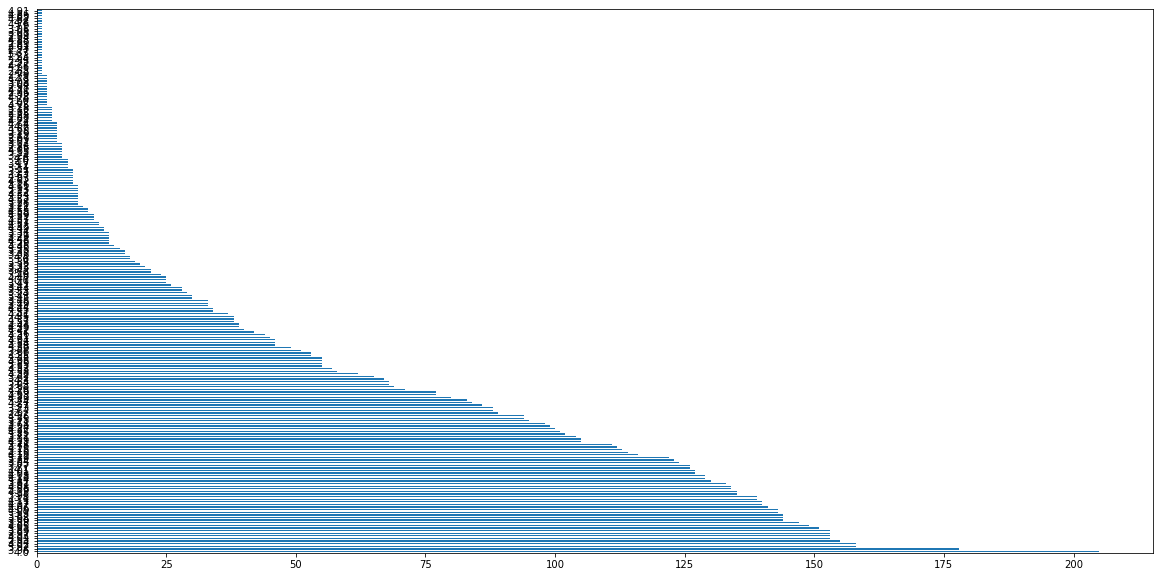

In [193]:
# Find how ratings are distributed
df['average_rating'].value_counts()
plt.figure(figsize=(20,10))
df['average_rating'].value_counts().plot(kind='barh')
#direct way using nunique() method applied to the Series
df['average_rating'].nunique() #too many unique values

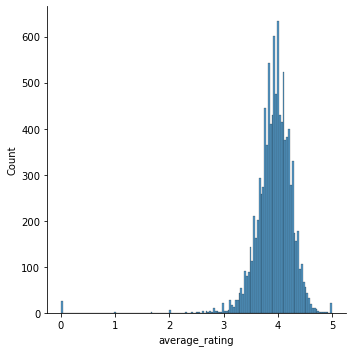

In [194]:
sns.displot(df.average_rating)

In [195]:
# Round values to max 1 decimal
df['avr_rating_rounded']=df['average_rating'].round(1)
df.head(3)
df['avr_rating_rounded'].nunique()

32

<AxesSubplot:>

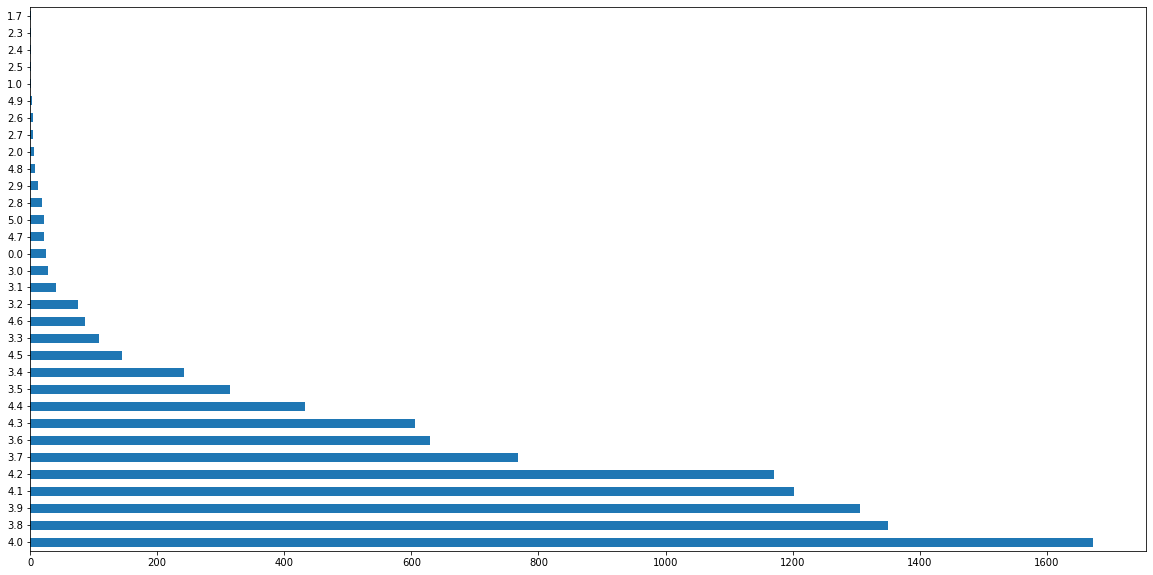

In [196]:
plt.figure(figsize=(20,10))
df['avr_rating_rounded'].value_counts().plot(kind='barh')

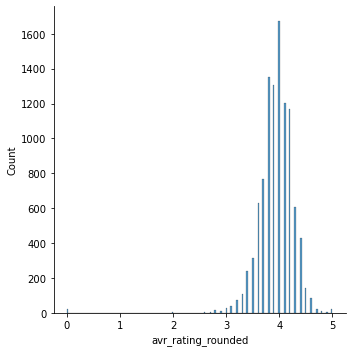

In [197]:
sns.displot(df.avr_rating_rounded)

In [198]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [ ]:
slots_avrrating={1:'married', 2:'single', 3:'others',0:'unknown'}

In order to apply the transformation to the `marriage` Series, we combine the use of `apply()` method with a **lambda function**.

The lambda function takes in input a numeric value x and  returns the corresponding category.

In [ ]:
lambda x: marital_status[x]

In [ ]:
df['marriage'].apply(lambda x: marital_status[x])

The transformed Series can be assigned to a new Series called `marriage_new`

In [ ]:
df['marriage_new']=df['marriage'].apply(lambda x: marital_status[x])

- DONE - DATA CLEANING - Inspect dataset: check datatypes, missing values, describe data
- DONE - DATA CLEANING - Spaces before the title num_pages -> Remove them
- DONE - DATA CLEANING - Transform publication date into datetime format 
- DATA TRANSFORMATION - Rating count value 0 with an average vote <> 0 -> Transform rating count into categories : a bit, medium, a lot with log function -> Remove data

- DONE - DATA CLEANING - Too many authors (until 51) -> Keep only the first author who is the writer 'main_author' (individuato perchè è scritto prima della ',')
- DONE - DATA CLEANING - Duplicates? - Common titles with different lines -> Keep the max value and add the number of votes
- DONE - DATA CLEANING - Num pages with data 0 -> For 15 of them take the data of the identical book -> The rest, average by publisher
- DONE - DATA CLEANING - 4 lines discrepency between title and data -> Fix data with the right column	
- DONE - DATA CLEANING - Publication date -> Split by year -> Split by season into numerical

- DATA TRANSFORMATION - Language, author and publisher -> Transform in numerical data
- DATA TRANSFORMATION - Transform num pages into category (low, medium, high) -> classic spliting 
- DATA TRANSFORMATION - Transform rating into category (bad, medium, good) -> log function (important data : 91% of data between 3,5 and 4,4, lloks like a normal law)	

- ANALYSIS PART - Create a column average of rating vote -> average by author (keep this one but demonstrate we thought about the other option)	ponderate average by nb of votes

- ISBN13 et 10 -> Find a table equivalent for region/ country	

- AT THE END - Useless column (idbook) -> Delete
- AT THE END - Remove other useless or redundant colums
- AT THE END - Change the order of the columns of the table putting at the beginning those that are the key for prediction purposes then other columns by importance


In [ ]:
# Sort dataset by ID and Start Date (in this order)
df1=df1.sort_values(['User Sys ID', 'Start Date'], ascending=True)
df1.head(20)

In [ ]:
#compute the average job duration

jobnaids = df1[df1["Job Duration"].isna()]["User Sys ID"]
jobnaidsstats = jobnaids.value_counts(dropna = False)
jobnaidsstats


In [ ]:
#average number of skills for each employee
#how many skills for same ID
#count how many observation for the same unit
tmp = df4.groupby("User Sys ID").agg({"User Sys ID": "count"})
df4.set_index("User Sys ID", inplace=True)
df4["N. tech skills"] = tmp
df4.reset_index(inplace=True)

avg_tech_skills = df4['N. tech skills'].mean()
avg_tech_skills

mode_tech_skills = df4['N. tech skills'].mode()[0]
mode_tech_skills

#n. skills wrt average
#df4['Tech_skills vs avg'] = df4['N. tech skills'] / avg_tech_skills

#n. skills wrt mode
df4['Tech_skills vs mode'] = df4['N. tech skills'] / mode_tech_skills

In [ ]:
dataset = pd.read_csv("books.csv", encoding='UTF-8',on_bad_lines='skip')
dataset = pd.read_csv("books-open-book.csv", encoding='UTF-8',on_bad_lines='skip')